<h1><center>Time Series Analysis and Forecasting for Network Link Utilization</center></h1>
<h2>
Name: Ayushman Anupam
</h2>

In [264]:
# ---------------- Importing needed libraries ----------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.holtwinters import ExponentialSmoothing

## ---------- SubTask 01. Description of the Data ----------

- **Dataset File**: `linkstats.csv`  
- **Dataset Size**: `21,704` rows × `7` columns  

In [265]:
# -------------- Loading Data ------------------

df=pd.read_csv("linkstats.csv")
print("Shape:",df.shape)

Shape: (21704, 7)


In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21704 entries, 0 to 21703
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          21704 non-null  int64  
 1   ifHCInOctets       21704 non-null  float64
 2   ifHCOutOctets      21704 non-null  float64
 3   ifInErrors         21704 non-null  float64
 4   ifOutErrors        21704 non-null  float64
 5   ifInUcastPackets   21704 non-null  float64
 6   ifOutUcastPackets  21704 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.2 MB


In [267]:
df.head()

,timestamp,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
0,1703858100,3380.495680,2876.390069,0.0,0.0,4.547973,4.646825
1,1703858400,3408.845196,3060.870004,0.0,0.0,4.684506,4.881705
2,1703858700,3378.864965,2789.810337,0.0,0.0,4.659316,4.735553
3,1703859000,3369.610477,3007.387779,0.0,0.0,4.510157,4.723786
4,1703859300,3411.716231,2774.699436,0.0,0.0,4.493931,4.608065


### Column Description
- `timestamp`: Time when the data was recorded (stored in **UNIX** format).  
- `ifHCInOctets`: Incoming traffic (bytes) on the network interface.  
- `ifHCOutOctets`: Outgoing traffic (bytes) on the network interface.  
- `ifInErrors`: Errors recorded on incoming traffic.  
- `ifOutErrors`: Errors recorded on outgoing traffic.  
- `ifInUcastPackets`: Unicast packets on incoming traffic.  
- `ifOutUcastPackets`: Unicast packets on outgoing traffic.  

### Additional Notes
- No **NULL** values found in the dataset.  
- No errors recorded in incoming and outgoing traffic.  
- Data appears to be clean.  


In [268]:
df.describe()

,timestamp,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
count,2.170400e+04,21704.000000,21704.000000,21704.0,21704.0,21704.000000,21704.000000
mean,1.707115e+09,3662.194603,3121.831474,0.0,0.0,5.849191,5.989371
std,1.881215e+06,2106.497138,2165.381802,0.0,0.0,7.300456,7.306464
min,1.703858e+09,3065.859687,1777.563807,0.0,0.0,4.029608,3.105736
25%,1.705486e+09,3186.130385,2581.760481,0.0,0.0,4.281504,4.410868
50%,1.707117e+09,3233.332602,2640.237080,0.0,0.0,4.401067,4.535204
75%,1.708745e+09,3313.122753,2750.465240,0.0,0.0,4.574064,4.708227
max,1.710373e+09,39759.369003,51812.894384,0.0,0.0,131.925956,131.954822


## ---------- Subtask 02. What questions are we addressing ----------
 
- What regression model can best capture and forecast the utilization for the next seven days?  
- What is the appropriate ARIMA model for forecasting future utilization, and how well does it perform?  
- Which exponential smoothing method is suitable for the data, and how do its forecasts compare?  
- How accurate and reliable are the forecasts from different models?  


In [269]:
# ------------ Dropping Errors column  and making timestamps as index ------------------

df = df.drop(['ifInErrors','ifOutErrors'], axis =1)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)
df.head()

,ifHCInOctets,ifHCOutOctets,ifInUcastPackets,ifOutUcastPackets
timestamp,,,,
2023-12-29 13:55:00,3380.495680,2876.390069,4.547973,4.646825
2023-12-29 14:00:00,3408.845196,3060.870004,4.684506,4.881705
2023-12-29 14:05:00,3378.864965,2789.810337,4.659316,4.735553
2023-12-29 14:10:00,3369.610477,3007.387779,4.510157,4.723786
2023-12-29 14:15:00,3411.716231,2774.699436,4.493931,4.608065


## ---------- Subtask 03. A plot of the data ----------

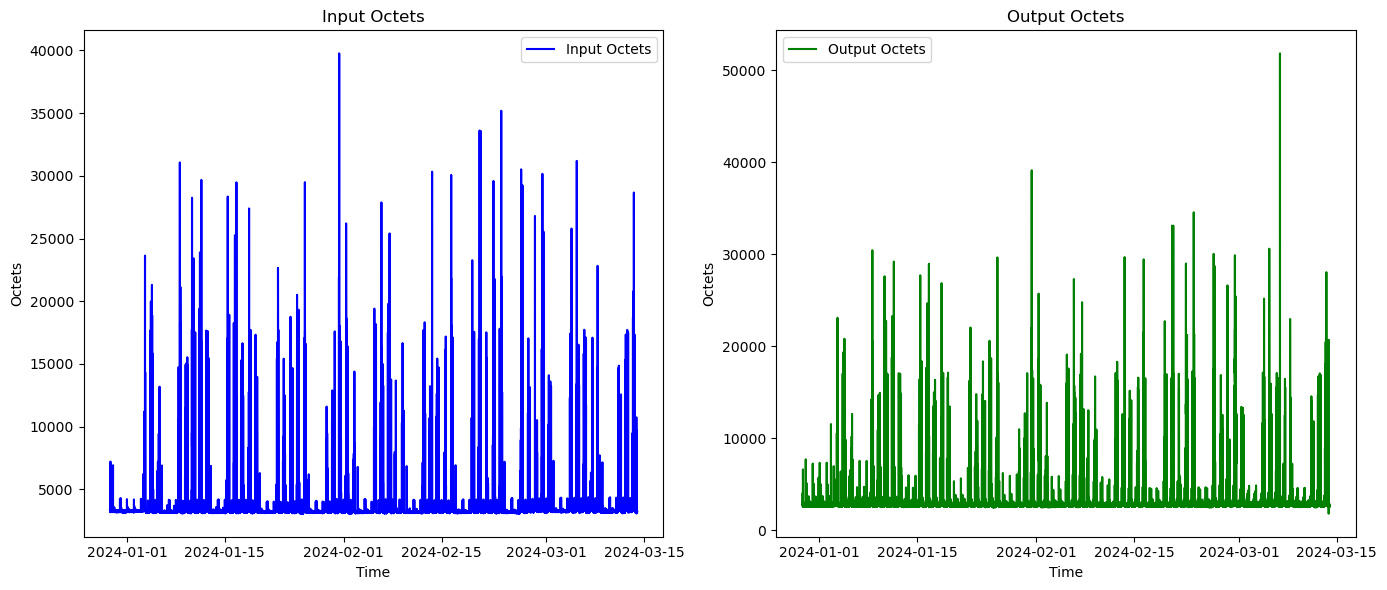

In [270]:
# ------------ plotting In and Out Octets ---------------

plt.figure(figsize=(14, 6))

# Plot 1: Input Octets
plt.subplot(1, 2, 1)
plt.plot(df['ifHCInOctets'], label='Input Octets', color='blue')
plt.title('Input Octets')
plt.xlabel('Time')
plt.ylabel('Octets')
plt.legend()

# Plot 2: Output Octets
plt.subplot(1, 2, 2)
plt.plot(df['ifHCOutOctets'], label='Output Octets', color='green')
plt.title('Output Octets')
plt.xlabel('Time')
plt.ylabel('Octets')
plt.legend()

plt.tight_layout()
plt.show()


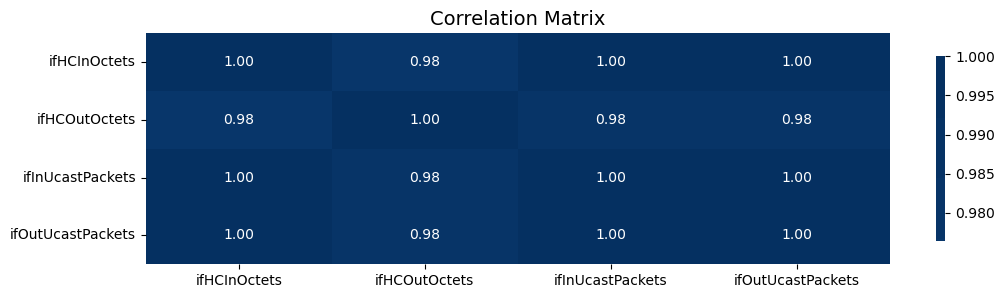

In [271]:
# Compute correlation matrix
corr = df.corr()

plt.figure(figsize=(12,3))
sns.heatmap(
    corr,
    annot=True,       
    cmap="RdBu",       # blue = +ve, red = -ve
    center=0,          
    fmt=".2f",         
    cbar_kws={"shrink": .8}
)

plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=0)
plt.show()


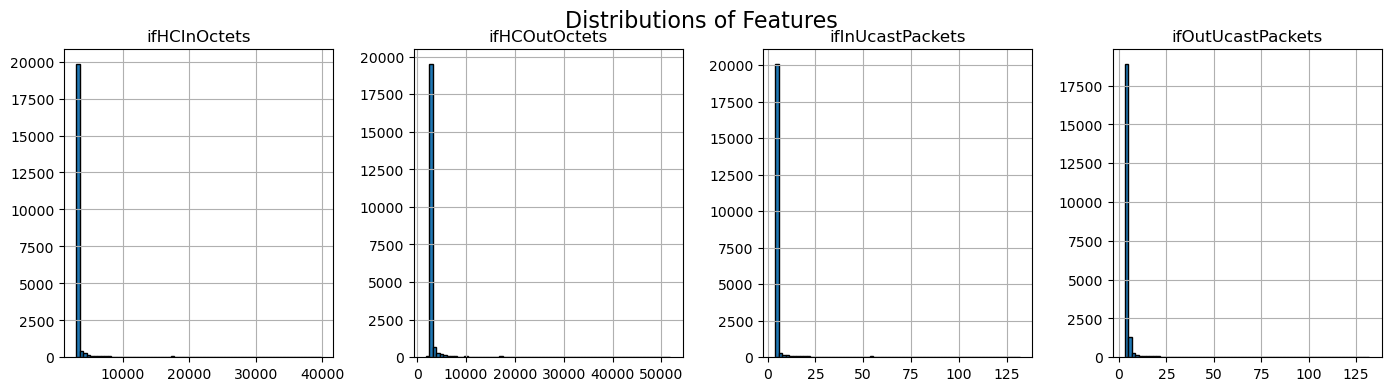

In [272]:
# -----------  Distribution of each feature -----------------
df.hist(
    figsize=(17, 4),
    bins=70,
    edgecolor='black',
    layout=(1, 4)
)

plt.suptitle("Distributions of Features", fontsize=16)
plt.show()


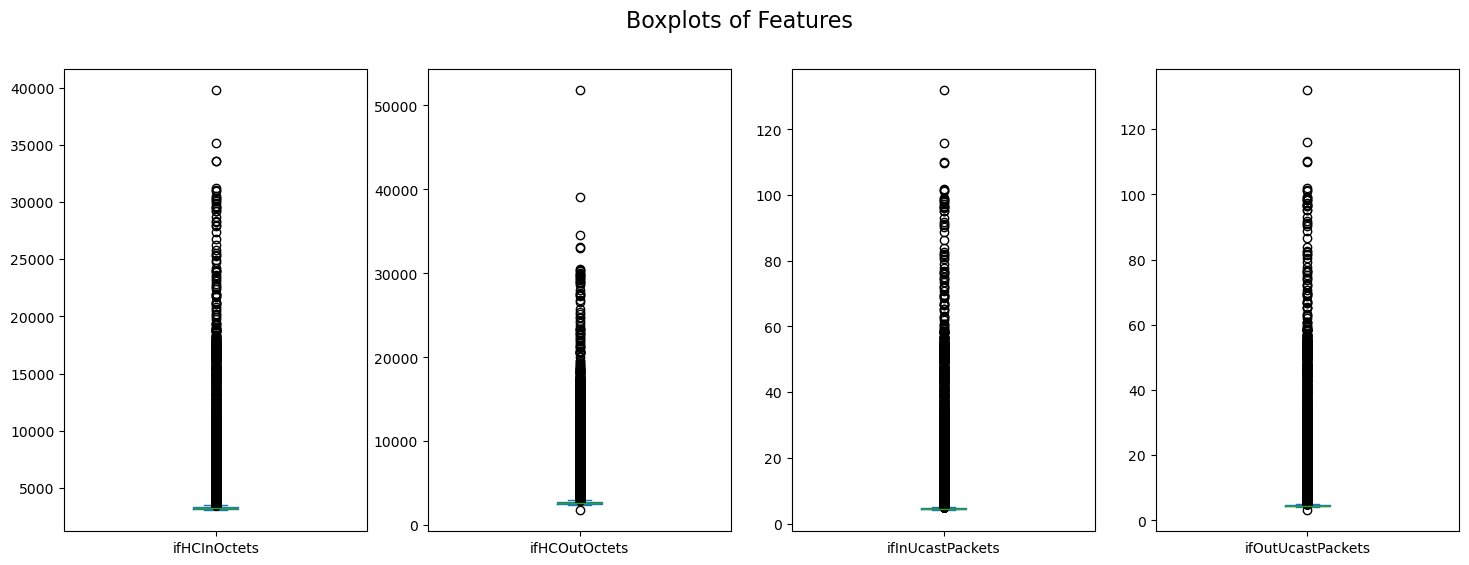

In [273]:
# ----------- Box plots to see outliers ----------------------
df.plot(kind='box', subplots=True, layout=(1,4), figsize=(18,6), sharex=False, sharey=False)
plt.suptitle("Boxplots of Features", fontsize=16)
plt.show()


## ---------- Data Augmentation to get hourly data  and "Total Link utilization" ----------

In [ ]:
# --------- Converting Octets into KiloByte -------------
# ----- I taking mean as total link utilization ------------
df = df.resample("1h").mean().dropna()
df['total_KB'] = (df['ifHCInOctets'] + df['ifHCOutOctets'])/1024
df.head()

,ifHCInOctets,ifHCOutOctets,ifInUcastPackets,ifOutUcastPackets,total_KB
timestamp,,,,,
2023-12-29 13:00:00,3380.495680,2876.390069,4.547973,4.646825,6.110240
2023-12-29 14:00:00,3460.771250,2888.468703,4.908369,5.022037,6.200430
2023-12-29 15:00:00,3639.167499,3123.803514,5.738568,5.842887,6.604464
2023-12-29 16:00:00,3242.343576,2609.232656,4.347367,4.409261,5.714430
2023-12-29 17:00:00,3245.300846,2610.064319,4.376476,4.436609,5.718130


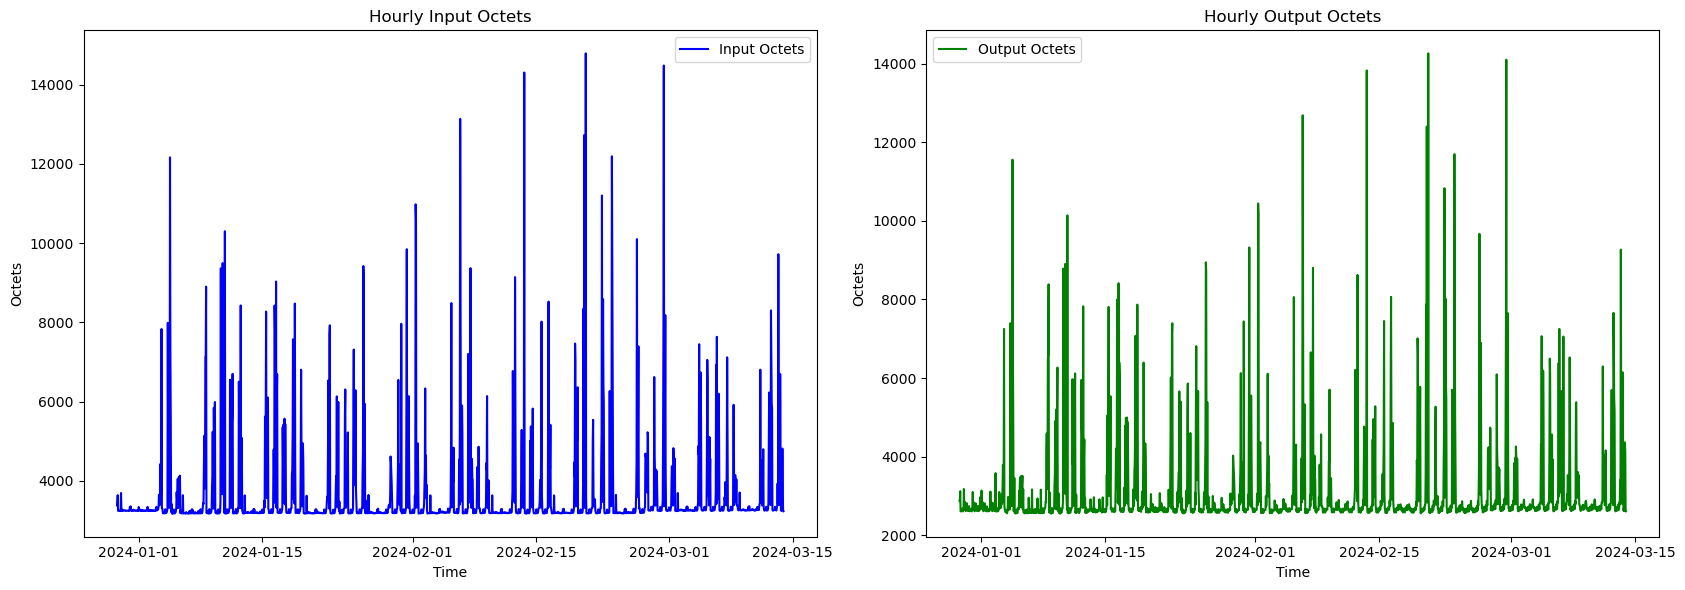

In [275]:
plt.figure(figsize=(17, 6))

# Plot 1: Input Octets
plt.subplot(1, 2, 1)
plt.plot(df['ifHCInOctets'], label='Input Octets', color='blue')
plt.title('Hourly Input Octets')
plt.xlabel('Time')
plt.ylabel('Octets')
plt.legend()

# Plot 2: Output Octets
plt.subplot(1, 2, 2)
plt.plot(df['ifHCOutOctets'], label='Output Octets', color='green')
plt.title('Hourly Output Octets')
plt.xlabel('Time')
plt.ylabel('Octets')
plt.legend()

plt.tight_layout()
plt.show()


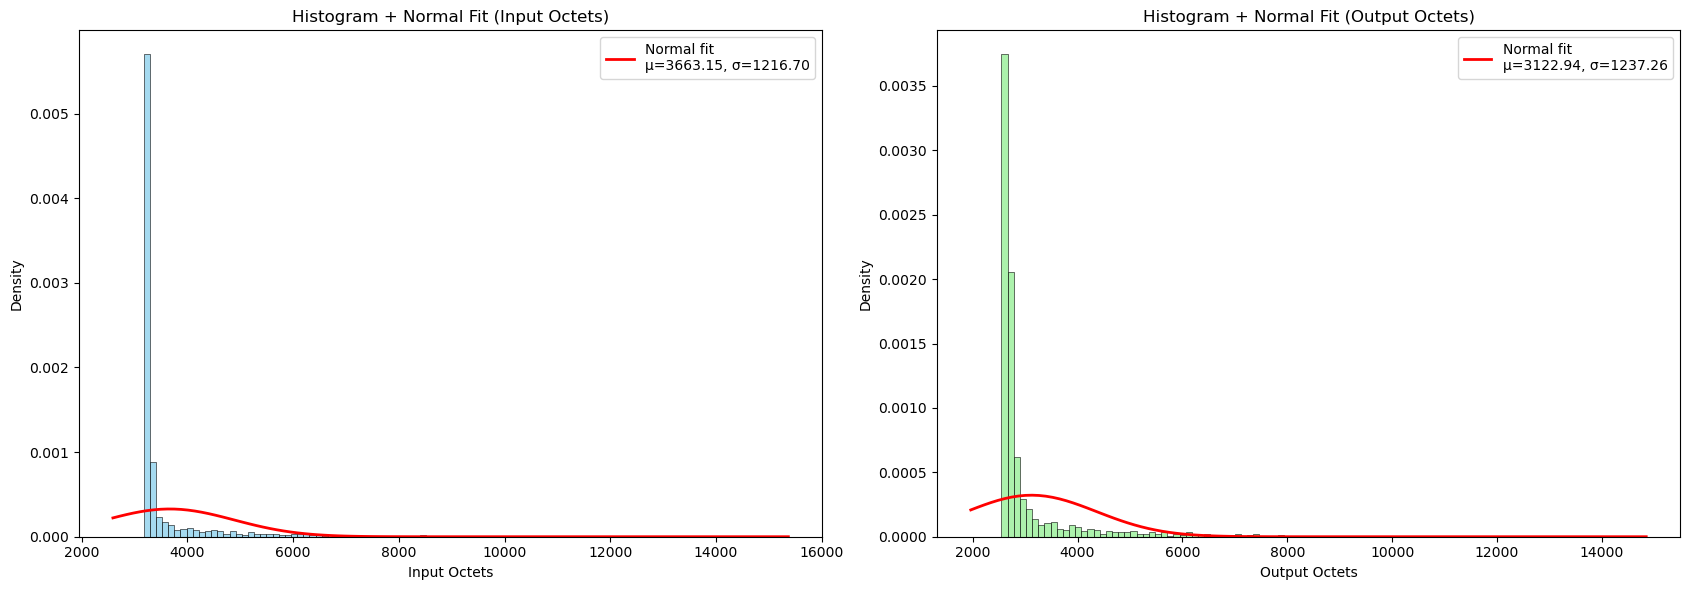

In [276]:
plt.figure(figsize=(17, 6))

# --- Plot 1: Input Octets ---
plt.subplot(1, 2, 1)
sns.histplot(df['ifHCInOctets'], bins=100, kde=False, color="skyblue", stat="density")

# Fit normal distribution
mu, sigma = norm.fit(df['ifHCInOctets'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2, label=f'Normal fit\nμ={mu:.2f}, σ={sigma:.2f}')

plt.title('Histogram + Normal Fit (Input Octets)')
plt.xlabel('Input Octets')
plt.ylabel('Density')
plt.legend()

# --- Plot 2: Output Octets ---
plt.subplot(1, 2, 2)
sns.histplot(df['ifHCOutOctets'], bins=100, kde=False, color="lightgreen", stat="density")

# Fit normal distribution
mu, sigma = norm.fit(df['ifHCOutOctets'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2, label=f'Normal fit\nμ={mu:.2f}, σ={sigma:.2f}')

plt.title('Histogram + Normal Fit (Output Octets)')
plt.xlabel('Output Octets')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


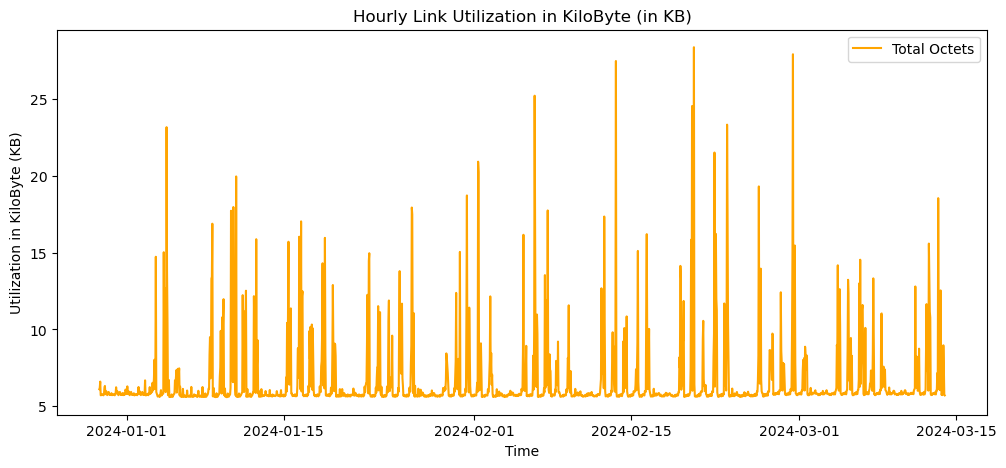

In [277]:
plt.figure(figsize=(12, 5))
plt.plot(df['total_KB'], label='Total Octets', color='orange')
plt.title('Hourly Link Utilization in KiloByte (in KB)')
plt.xlabel('Time')
plt.ylabel('Utilization in KiloByte (KB)')
plt.legend()
plt.show()


## Main Task 01: Regression for link utilisation in KiloByte(KB)

### Feature Engineering for regression

In [278]:
"""
I am doing feature engineering intoducing 30 new features mainly for current data point new feature are 
1. past 25 link utilization in KiloByte(KB)
2. past 168th point and past and next 2 points from past 168th point
(from data is clear that that there is weekly periodicity i.e current point depends on past 168th dat)
"""
max_lag = 25
total_lags = 30

# Original lag features
df_lags = pd.DataFrame({"y": df['total_KB'].squeeze()})
for lag in range(1, max_lag + 1):
    df_lags[f"lag_{lag}"] = df_lags["y"].shift(lag)

# Compute extra 5 lags from previous 168 points
extra_lags = total_lags - max_lag  # 5
history_window = df_lags['y'].iloc[-(168 + extra_lags*2):-168]  # pick previous 168 points

for i in range(extra_lags):
    # Take 2 consecutive points as one lag (adjust indices as needed)
    df_lags[f"lag_{max_lag + i + 1}"] = df_lags['y'].shift(max_lag + i + 1)

df_lags.dropna(inplace=True)


In [279]:
X = df_lags.drop("y", axis=1).values
y = df_lags["y"].values


# --- Train/Test Split ---
split = len(y) - 168 
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
time_index = df_lags.index


# --- Fit regression ---
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

### ----------- Prediction using Lag from Actual Lag ---------------

**Predicting the last 7 days of link utilization using past 30 datapoints**

For each prediction step, we use the **30 actual previous values** as features. For example, to predict $t_1$, we use the 30 values before it; to predict $t_2$, we again use the 30 actual preceding values, and so on.

**Note:** In practice, we wouldn’t know future values (e.g., $t_1, t_2, …$) when predicting later steps. Using actual future values as features **cheats the model** and can overstate performance. For real deployment, predictions should rely only on known past data.

In [280]:
# --- Predictions ---
reg_y_pred = reg_model.predict(X_test)

# --- Evaluation metrics ---
mse = mean_squared_error(y_test, reg_y_pred)
rmse = root_mean_squared_error(y_test, reg_y_pred)
mae = mean_absolute_error(y_test, reg_y_pred)
r2 = r2_score(y_test, reg_y_pred)
mape = np.mean(np.abs((y_test - reg_y_pred) / y_test)) * 100

print("Regression Model Evaluation Metrics using actual lag :")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")


Regression Model Evaluation Metrics using actual lag :
MSE  : 3.05
RMSE : 1.75
MAE  : 0.95
R²   : 0.1852
MAPE : 12.13%


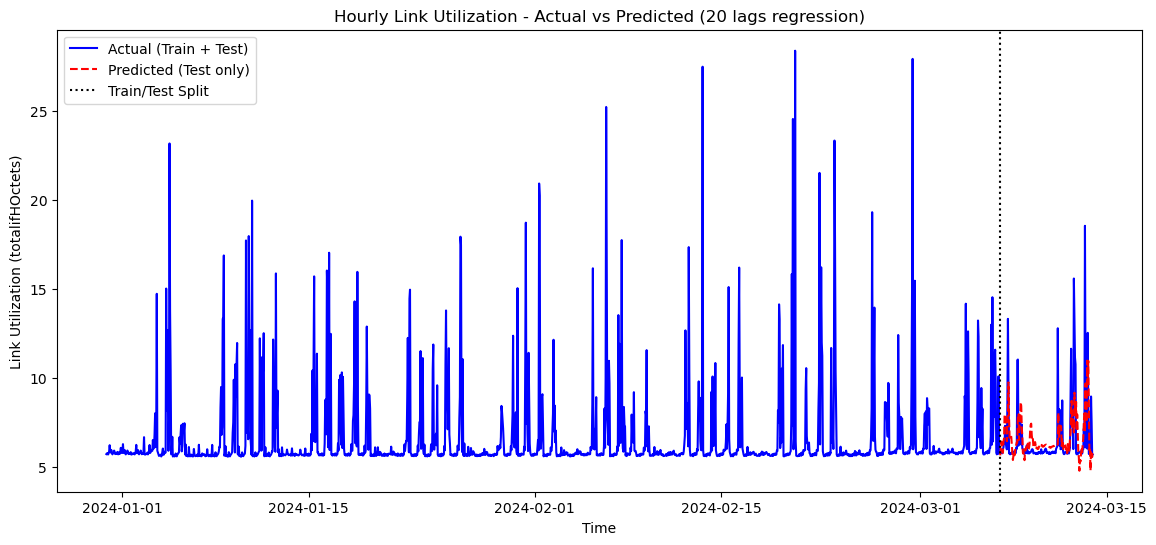

In [281]:
plt.figure(figsize=(14,6))

plt.plot(time_index, y, label="Actual (Train + Test)", color="blue")

plt.plot(time_index[split:], reg_y_pred, label="Predicted (Test only)", color="red", linestyle="--")
plt.axvline(time_index[split], color="black", linestyle=":", label="Train/Test Split")

plt.title("Hourly Link Utilization - Actual vs Predicted (20 lags regression)")
plt.xlabel("Time")
plt.ylabel("Link Utilization (totalifHOctets)")
plt.legend()
plt.show()


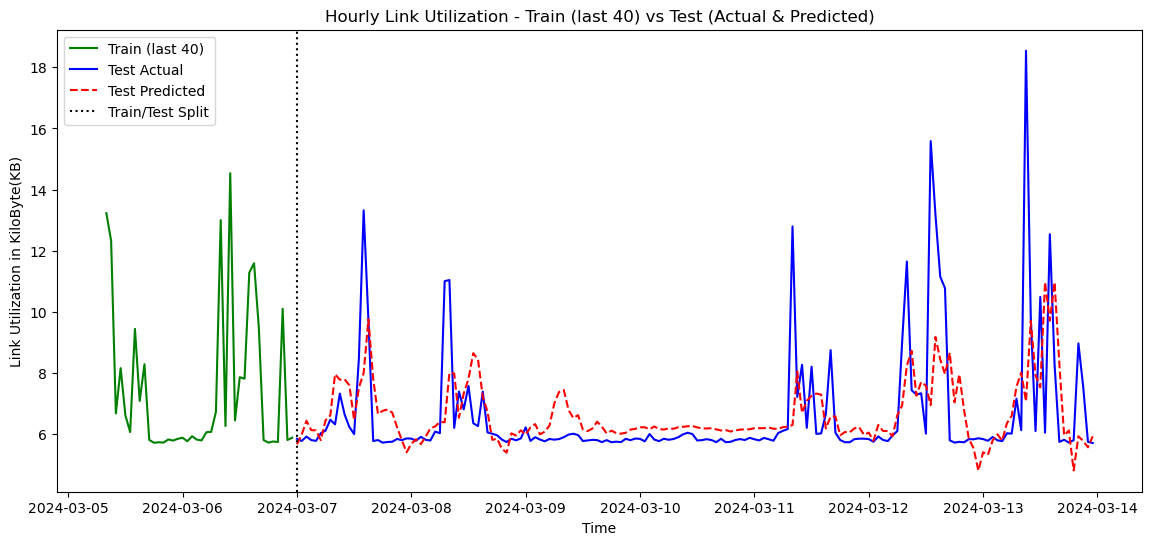

In [282]:
plt.figure(figsize=(14,6))

plt.plot(time_index[split-40:split], y[split-40:split], 
         label="Train (last 40)", color="green")
plt.plot(time_index[split:], y[split:], 
         label="Test Actual", color="blue")
plt.plot(time_index[split:], reg_y_pred, 
         label="Test Predicted", color="red", linestyle="--")
plt.axvline(time_index[split], color="black", linestyle=":", label="Train/Test Split")

plt.title("Hourly Link Utilization - Train (last 40) vs Test (Actual & Predicted)")
plt.xlabel("Time")
plt.ylabel("Link Utilization in KiloByte(KB)")
plt.legend()
plt.show()


### ----------- Prediction using Lag from predicted Lag ---------------

For each prediction step $t_n$:

1. **When $n \le \text{max\_lag}$**:

   * The model uses the last $n$ predicted values (from previous steps) along with the remaining $\text{max\_lag} - n$ actual observed values from the training set to form the input feature vector.

2. **When $n > \text{max\_lag}$**:

   * The model already has enough predicted values to fill the full lag window.
   * The input for $t_n$ is constructed entirely from the previously predicted values, with no need for actual observations.

This process is repeated recursively for all future steps, so that each prediction $t_n$ depends on a combination of past actual values and the model’s own previous predictions.

In [283]:
reg_rec_y_pred = []
history = list(y_train)
past_168 = list(y_train[-168:])  

for t in range(len(y_test)):
    X_input = history[-25:]  

    lag_26 = past_168[0] 
    X_input.append(lag_26)

    lag_27_30 = past_168[:4] 
    X_input.extend(lag_27_30)
    X_input = np.array(X_input).reshape(1, -1)
    yhat = reg_model.predict(X_input)[0]
    reg_rec_y_pred.append(yhat)
    history.append(yhat)
reg_rec_y_pred = np.array(reg_rec_y_pred)


In [284]:
# --- Evaluation metrics ---
mse = mean_squared_error(y_test, reg_rec_y_pred)
rmse = root_mean_squared_error(y_test, reg_rec_y_pred)
mae = mean_absolute_error(y_test, reg_rec_y_pred)
r2 = r2_score(y_test, reg_rec_y_pred)
mape = np.mean(np.abs((y_test - reg_rec_y_pred) / y_test)) * 100

print("Regression Model Evaluation Metrics on predicted Lag:")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")

Regression Model Evaluation Metrics on predicted Lag:
MSE  : 4.22
RMSE : 2.05
MAE  : 1.45
R²   : -0.1286
MAPE : 20.29%


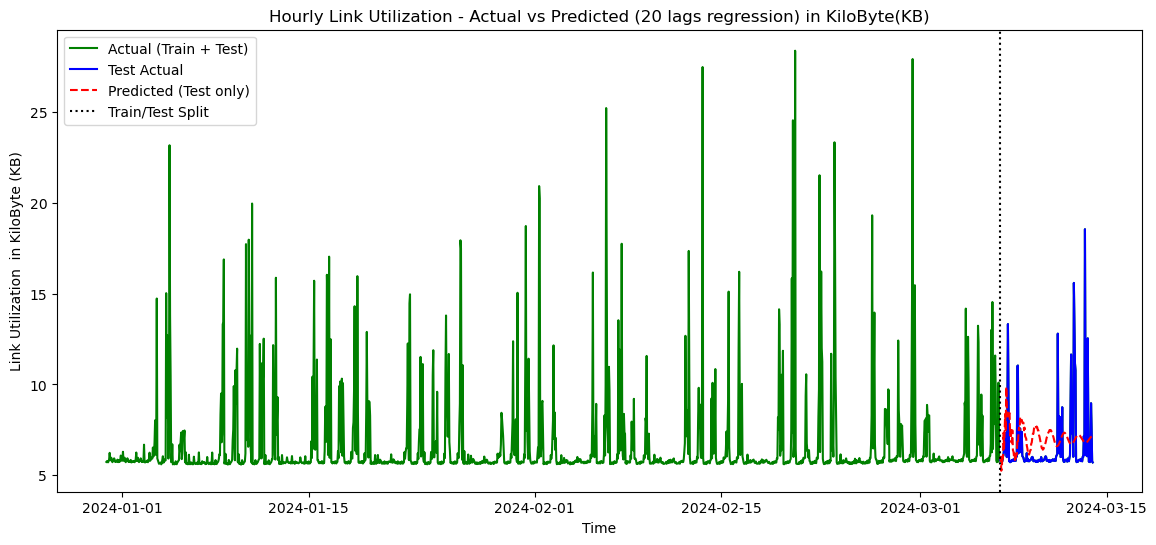

In [285]:
plt.figure(figsize=(14,6))

plt.plot(time_index, y, label="Actual (Train + Test)", color="green")
plt.plot(time_index[split:], y[split:],label="Test Actual", color="blue")
plt.plot(time_index[split:], reg_rec_y_pred, label="Predicted (Test only)", color="red", linestyle="--")
plt.axvline(time_index[split], color="black", linestyle=":", label="Train/Test Split")

plt.title("Hourly Link Utilization - Actual vs Predicted (20 lags regression) in KiloByte(KB)")
plt.xlabel("Time")
plt.ylabel("Link Utilization  in KiloByte (KB)")
plt.legend()
plt.show()


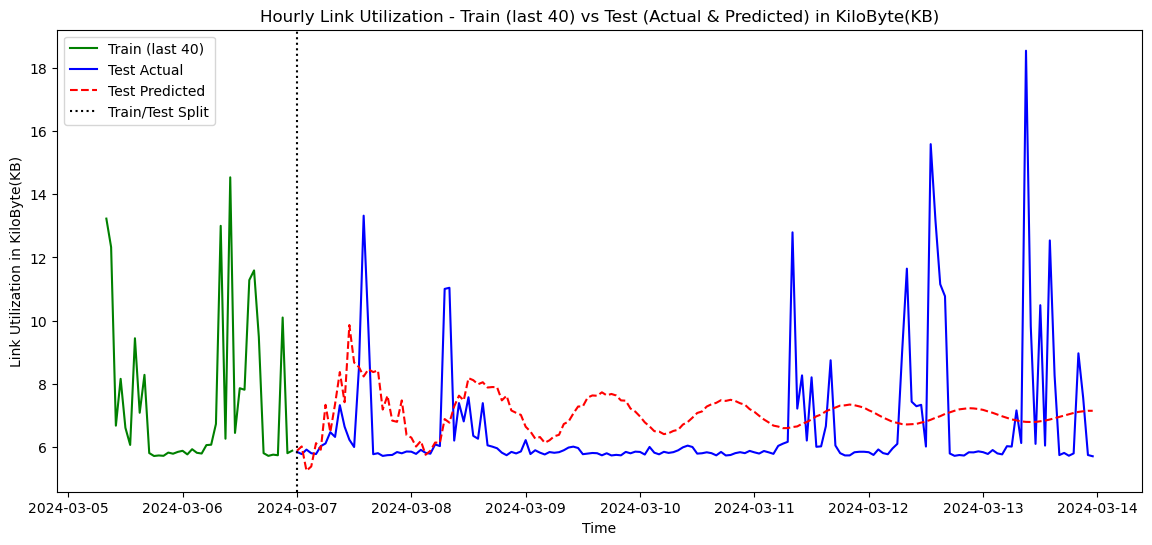

In [286]:
plt.figure(figsize=(14,6))

plt.plot(time_index[split-40:split], y[split-40:split], 
         label="Train (last 40)", color="green")
plt.plot(time_index[split:], y[split:], 
         label="Test Actual", color="blue")
plt.plot(time_index[split:], reg_rec_y_pred, 
         label="Test Predicted", color="red", linestyle="--")
plt.axvline(time_index[split], color="black", linestyle=":", label="Train/Test Split")

plt.title("Hourly Link Utilization - Train (last 40) vs Test (Actual & Predicted) in KiloByte(KB)")
plt.xlabel("Time")
plt.ylabel("Link Utilization in KiloByte(KB)")
plt.legend()
plt.show()


## Task 02: ARIMA model for the hourly utilisation in KiloByte(KB)

### Stationarity Tests for data

In [287]:
def stationarity_tests(series, signif=0.05, name="Series"):
    results = {}

    print(f"\n=== Stationarity Tests for {name} ===")

    # ADF Test
    adf_stat, adf_p, lags, n_obs, crit, icbest = adfuller(series, autolag='AIC')
    print("\n--- Augmented Dickey-Fuller (ADF) Test ---")
    print(f"ADF Statistic : {adf_stat}")
    print(f"p-value       : {adf_p}")
    print(f"Critical Values: {crit}")

    results["ADF_Stationary"] = adf_p <= signif

    if results["ADF_Stationary"]:
        print("✅ Reject H0 (unit root) → Series is STATIONARY (ADF)")
    else:
        print("❌ Fail to reject H0 → Series is NON-STATIONARY (ADF)")

    # KPSS Test with warning suppression
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kpss_stat, kpss_p, lags, crit = kpss(series, regression="c", nlags="auto")

    print("\n--- KPSS Test ---")
    print(f"KPSS Statistic : {kpss_stat}")
    print(f"p-value        : {kpss_p}")
    print(f"Critical Values: {crit}")

    results["KPSS_Stationary"] = kpss_p > signif

    if results["KPSS_Stationary"]:
        print("✅ Fail to reject H0 (stationarity) → Series is STATIONARY (KPSS)")
    else:
        print("❌ Reject H0 → Series is NON-STATIONARY (KPSS)")

    # Final Verdict
    print("\n=== Final Verdict ===")
    if results["ADF_Stationary"] and results["KPSS_Stationary"]:
        print("✅ Both tests agree → The series is STATIONARY.")
    elif not results["ADF_Stationary"] and not results["KPSS_Stationary"]:
        print("❌ Both tests agree → The series is NON-STATIONARY.")
    else:
        print("⚠️ Mixed results → The series may be TREND-stationary. Consider differencing/detrending.")

    return results

In [288]:
stationarity_tests(df['total_KB'] , name="Total utilization in KiloByte (KB)")


=== Stationarity Tests for Total utilization in KiloByte (KB) ===

--- Augmented Dickey-Fuller (ADF) Test ---
ADF Statistic : -5.25852831757714
p-value       : 6.669400522801816e-06
Critical Values: {'1%': -3.434018755659214, '5%': -2.8631605515716476, '10%': -2.5676327303470408}
✅ Reject H0 (unit root) → Series is STATIONARY (ADF)

--- KPSS Test ---
KPSS Statistic : 0.1263895898002503
p-value        : 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
✅ Fail to reject H0 (stationarity) → Series is STATIONARY (KPSS)

=== Final Verdict ===
✅ Both tests agree → The series is STATIONARY.


{'ADF_Stationary': True, 'KPSS_Stationary': True}

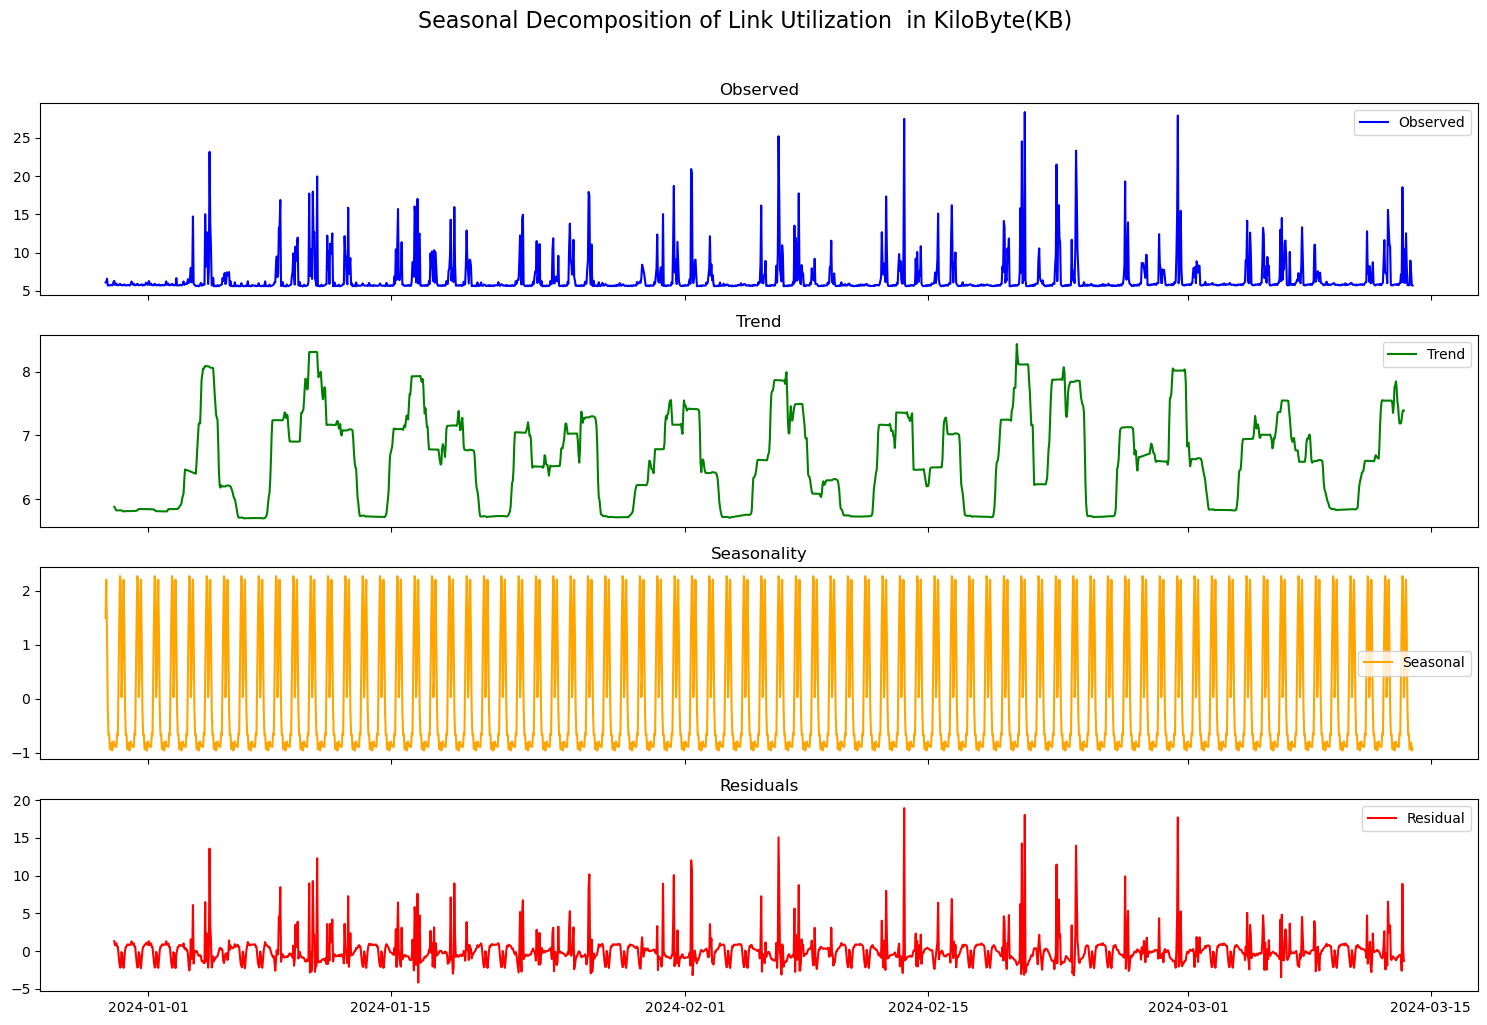

In [289]:
# ------------- Breaking down components of series into trends, seasonality and residuals ------------------

result = seasonal_decompose(df['total_KB'], model='additive', period=24)

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

axes[0].plot(result.observed, label="Observed", color="blue")
axes[0].set_title("Observed")
axes[0].legend()

axes[1].plot(result.trend, label="Trend", color="green")
axes[1].set_title("Trend")
axes[1].legend()

axes[2].plot(result.seasonal, label="Seasonal", color="orange")
axes[2].set_title("Seasonality")
axes[2].legend()

axes[3].plot(result.resid, label="Residual", color="red")
axes[3].set_title("Residuals")
axes[3].legend()

plt.suptitle("Seasonal Decomposition of Link Utilization  in KiloByte(KB)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


## ---------- Subtask 04: An estimated ACF and PACF ----------

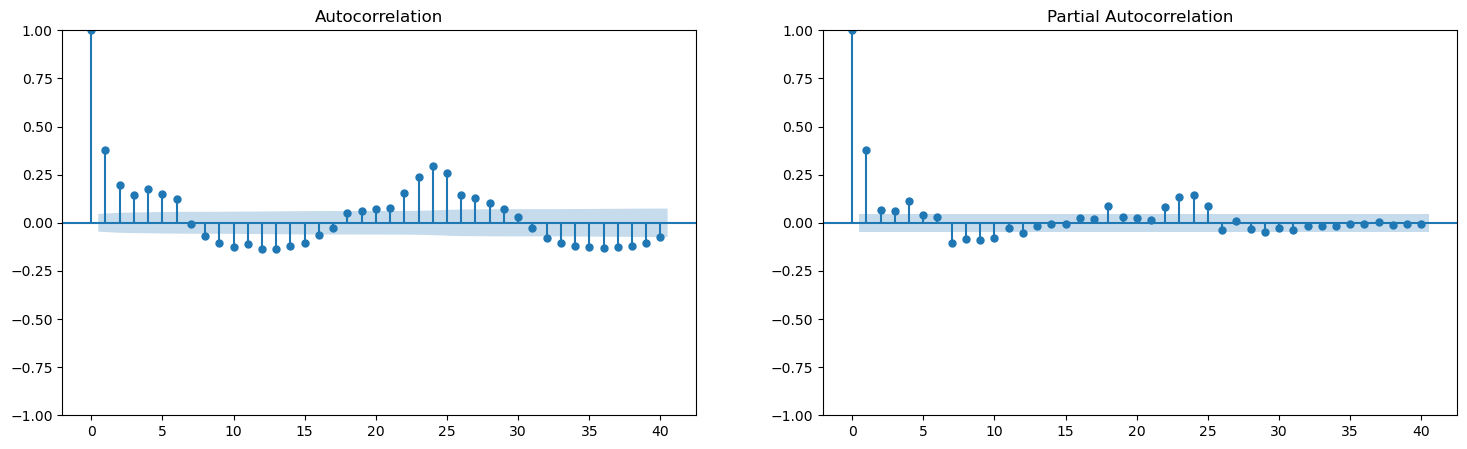

In [290]:
# ---------------plotting ACF and PACF ---------------

series = df['total_KB']
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
plot_acf(series, lags=40, ax=axes[0])
plot_pacf(series, lags=40, ax=axes[1])
plt.show()

In [291]:
# ------------------- Getting potential values for p, q using maximum dip from ACF and PACF curve -----------------------

def pq_top_dips(series, nlags=40, top_n=2, min_lag=5):

    acf_vals = acf(series, nlags=nlags, fft=False)
    pacf_vals = pacf(series, nlags=nlags, method='yw')
    acf_vals[0] = pacf_vals[0] = np.nan

    acf_diffs = np.diff(acf_vals)
    pacf_diffs = np.diff(pacf_vals)
    acf_sorted = np.argsort(acf_diffs) + 1
    pacf_sorted = np.argsort(pacf_diffs) + 1

    acf_candidates = [lag for lag in acf_sorted if lag >= min_lag][:top_n]
    pacf_candidates = [lag for lag in pacf_sorted if lag >= min_lag][:top_n]

    print("Top PACF dips (p candidates, lag ≥ 5):")
    for i, lag in enumerate(pacf_candidates, 1):
        print(f"{i}. Lag {lag}, drop={pacf_diffs[lag-1]:.4f}")

    print("\nTop ACF dips (q candidates, lag ≥ 5):")
    for i, lag in enumerate(acf_candidates, 1):
        print(f"{i}. Lag {lag}, drop={acf_diffs[lag-1]:.4f}")

    return pacf_candidates, acf_candidates
p_candidates, q_candidates = pq_top_dips(series, nlags=40)

Top PACF dips (p candidates, lag ≥ 5):
1. Lag 7, drop=-0.1364
2. Lag 26, drop=-0.1258

Top ACF dips (q candidates, lag ≥ 5):
1. Lag 7, drop=-0.1264
2. Lag 26, drop=-0.1144


In [292]:
# ---------- Getting and training ARIMA with potential (p, d = 0, q) to get best fit -----------

warnings.filterwarnings("ignore")
p_candidates = [6, 7, 26]
q_candidates = [6, 8, 26]
d = 0
# --- Data ---
series = df['total_KB']
train, test = series[:-168], series[-168:]
results = []

# --- Train and Evaluate ARIMA models ---
for p in p_candidates:
    for q in q_candidates:
        order = (p, d, q)
        model = ARIMA(train, order=order)
        fit = model.fit()
        forecast = fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)
        results.append(((p, 0, q), mse, fit.aic, fit.bic, forecast))
        print(f"ARIMA{order} -> MSE={mse:.2f}, AIC={fit.aic:.2f}, BIC={fit.bic:.2f}")


# --- Sort results by MSE ---
results = sorted(results, key=lambda x: x[1])


ARIMA(6, 0, 6) -> MSE=3.51, AIC=7225.60, BIC=7301.26
ARIMA(6, 0, 8) -> MSE=3.40, AIC=7226.05, BIC=7312.52
ARIMA(6, 0, 26) -> MSE=3.60, AIC=7186.72, BIC=7370.46
ARIMA(7, 0, 6) -> MSE=3.28, AIC=7220.89, BIC=7301.96
ARIMA(7, 0, 8) -> MSE=3.74, AIC=7282.22, BIC=7374.09
ARIMA(7, 0, 26) -> MSE=3.60, AIC=7188.09, BIC=7377.24
ARIMA(26, 0, 6) -> MSE=3.52, AIC=7181.85, BIC=7365.60
ARIMA(26, 0, 8) -> MSE=3.53, AIC=7185.98, BIC=7380.53
ARIMA(26, 0, 26) -> MSE=3.18, AIC=7205.20, BIC=7497.04


## ---------- Subtask 5. An estimated ARIMA Model and its parameters ----------

In [293]:
# --- Top 3 models ---
print("\nTop 3 ARIMA models:")

top_models = {}
for rank, (order, mse, aic, bic, _) in enumerate(results[:3], start=1):
    print(f"Rank {rank}: ARIMA{order} -> MSE={mse:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
    top_models[rank] = {"p": order[0], "d": order[1], "q": order[2]}

# print("\nStored Top Models Dict:")
# print(top_models)


Top 3 ARIMA models:
Rank 1: ARIMA(26, 0, 26) -> MSE=3.18, AIC=7205.20, BIC=7497.04
Rank 2: ARIMA(7, 0, 6) -> MSE=3.28, AIC=7220.89, BIC=7301.96
Rank 3: ARIMA(6, 0, 8) -> MSE=3.40, AIC=7226.05, BIC=7312.52


In [294]:
# ----------------- Best model and parameter (p, d, q) ---------------

# Top 3 ARIMA models:
# Rank 1: ARIMA(26, 0, 26) -> MSE=3.18, AIC=7205.20, BIC=7497.04
# Rank 2: ARIMA(7, 0, 6) -> MSE=3.28, AIC=7220.89, BIC=7301.96
# Rank 3: ARIMA(6, 0, 8) -> MSE=3.40, AIC=7226.05, BIC=7312.52
best_order, best_mse, best_aic, best_bic, ARIMA_y_pred = results[0]
best_order

(26, 0, 26)

In [295]:
# --- Evaluation metrics ---

mse = mean_squared_error(y_test, ARIMA_y_pred)
rmse = root_mean_squared_error(y_test, ARIMA_y_pred)
mae = mean_absolute_error(y_test, ARIMA_y_pred)
r2 = r2_score(y_test, ARIMA_y_pred)
mape = np.mean(np.abs((y_test - ARIMA_y_pred) / y_test)) * 100

print("ARIMA Model Evaluation Metrics:")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")

ARIMA Model Evaluation Metrics:
MSE  : 3.18
RMSE : 1.78
MAE  : 1.04
R²   : 0.1492
MAPE : 13.42%


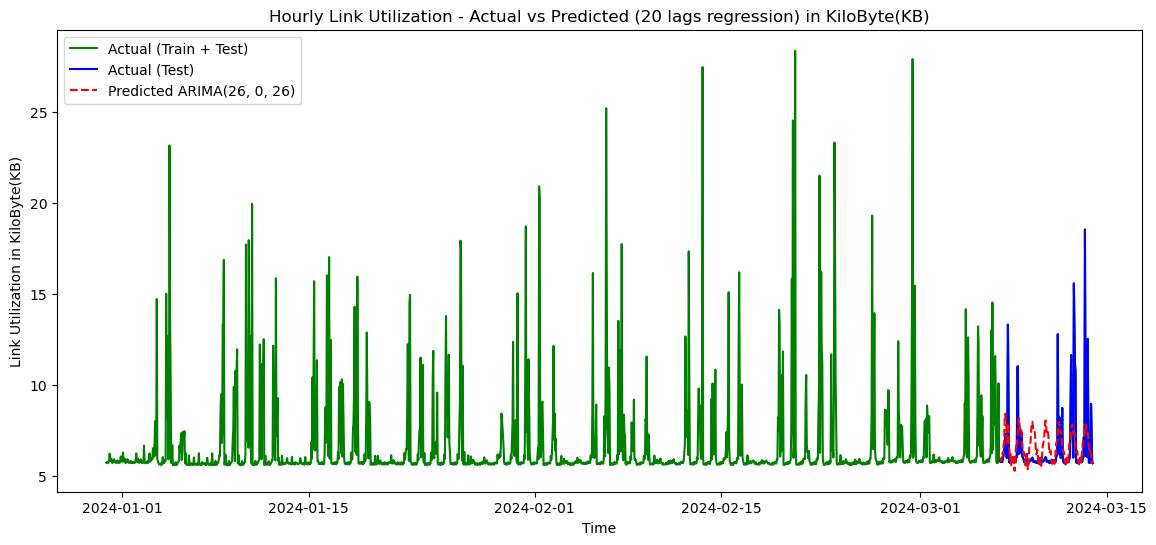

In [296]:
plt.figure(figsize=(14,6))
plt.plot(time_index, y, label="Actual (Train + Test)", color="green")
plt.plot(series.index[-168:], test, label="Actual (Test)", color="blue")
plt.plot(series.index[-168:], ARIMA_y_pred, label=f"Predicted ARIMA{best_order}", color="red", linestyle="--")
plt.title("Hourly Link Utilization - Actual vs Predicted (20 lags regression) in KiloByte(KB)")
plt.xlabel("Time")
plt.ylabel("Link Utilization in KiloByte(KB)")
plt.legend()
plt.show()


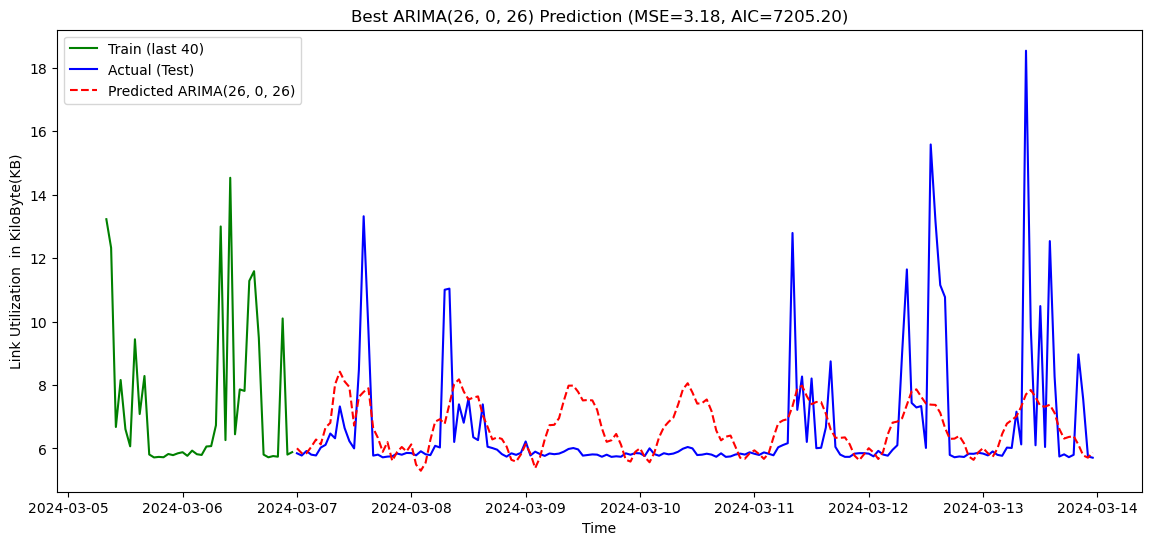

In [297]:
# --- Plot best model ---
plt.figure(figsize=(14, 6))

plt.plot(time_index[split-40:split], y[split-40:split], 
         label="Train (last 40)", color="green")
plt.plot(series.index[-168:], test, label="Actual (Test)", color="blue")
plt.plot(series.index[-168:], ARIMA_y_pred, label=f"Predicted ARIMA{best_order}", color="red", linestyle="--")
plt.title(f"Best ARIMA{best_order} Prediction (MSE={best_mse:.2f}, AIC={best_aic:.2f})")
plt.xlabel("Time")
plt.ylabel("Link Utilization  in KiloByte(KB)")
plt.legend()
plt.show()

## Main Task 03: Exponential smoothing method for the hourly network utilisation data

In [305]:
# ---------------- Training Exponential Smoothing ------------------

train, test = series[:-168], series[-168:]
exp_model = ExponentialSmoothing(
    train,
    trend='add',                 # 'add', 'mul'
    seasonal='add',              # 'add', 'mul'
    seasonal_periods= 168
)
exp_fit = exp_model.fit(optimized=True)

In [306]:
# --- Evaluation metrics ---
exp_y_pred = exp_fit.forecast(len(test))
mse = mean_squared_error(y_test, exp_y_pred)
rmse = root_mean_squared_error(y_test, exp_y_pred)
mae = mean_absolute_error(y_test, exp_y_pred)
r2 = r2_score(y_test, exp_y_pred)
mape = np.mean(np.abs((y_test - exp_y_pred) / y_test)) * 100

print("Exponential Model Evaluation Metrics:")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")

Exponential Model Evaluation Metrics:
MSE  : 2.96
RMSE : 1.72
MAE  : 0.85
R²   : 0.2085
MAPE : 10.73%


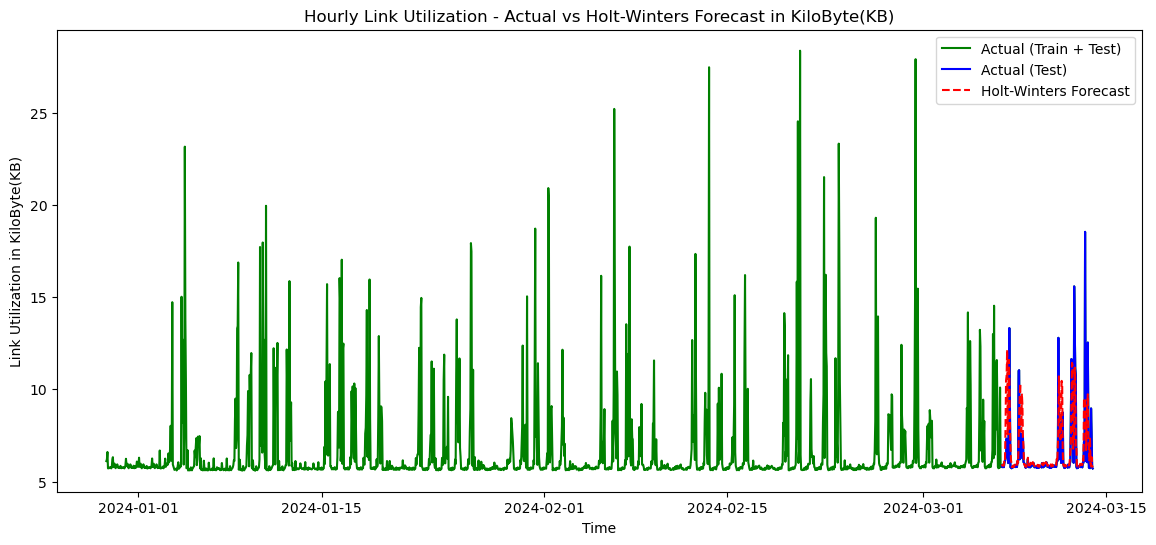

In [307]:
# --- Holt-Winters Forecast Plot ---
plt.figure(figsize=(14,6))
plt.plot(series.index, series, label="Actual (Train + Test)", color="green")
plt.plot(test.index, test, label="Actual (Test)", color="blue")
plt.plot(test.index, exp_y_pred, label="Holt-Winters Forecast", color="red", linestyle="--")
plt.title("Hourly Link Utilization - Actual vs Holt-Winters Forecast in KiloByte(KB)")
plt.xlabel("Time")
plt.ylabel("Link Utilization in KiloByte(KB)")
plt.legend()
plt.show()


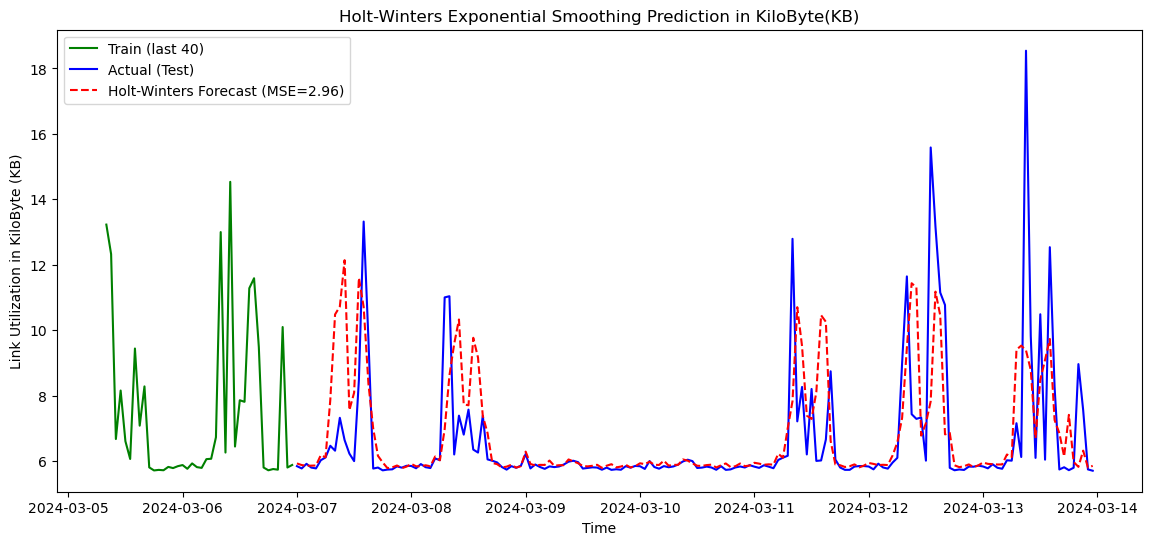

In [308]:
# --- Plot Holt-Winters best model ---
plt.figure(figsize=(14, 6))
plt.plot(time_index[split-40:split], y[split-40:split], label="Train (last 40)", color="green")
plt.plot(series.index[-168:], test, label="Actual (Test)", color="blue")
plt.plot(series.index[-168:], exp_y_pred, label=f"Holt-Winters Forecast (MSE={mse:.2f})", color="red", linestyle="--")
plt.title("Holt-Winters Exponential Smoothing Prediction in KiloByte(KB)")
plt.xlabel("Time")
plt.ylabel("Link Utilization in KiloByte (KB)")
plt.legend()
plt.show()


## ---------- Subtask 06: some analysis of residuals ----------

In [309]:
# -------- Calculating Residuals -----------
exp_residual = y[-168:] - exp_y_pred
ARIMA_residual = y[-168:] - ARIMA_y_pred
reg_residual = y[-168:] - reg_y_pred
reg_rec_residual = y[-168:] - reg_rec_y_pred

residuals = {
    "Regression Residual": reg_residual,
    "Recursive Regression Residual": reg_rec_residual,
    "ARIMA Residual": ARIMA_residual,
    "Exponential Smoothing Residual": exp_residual
}


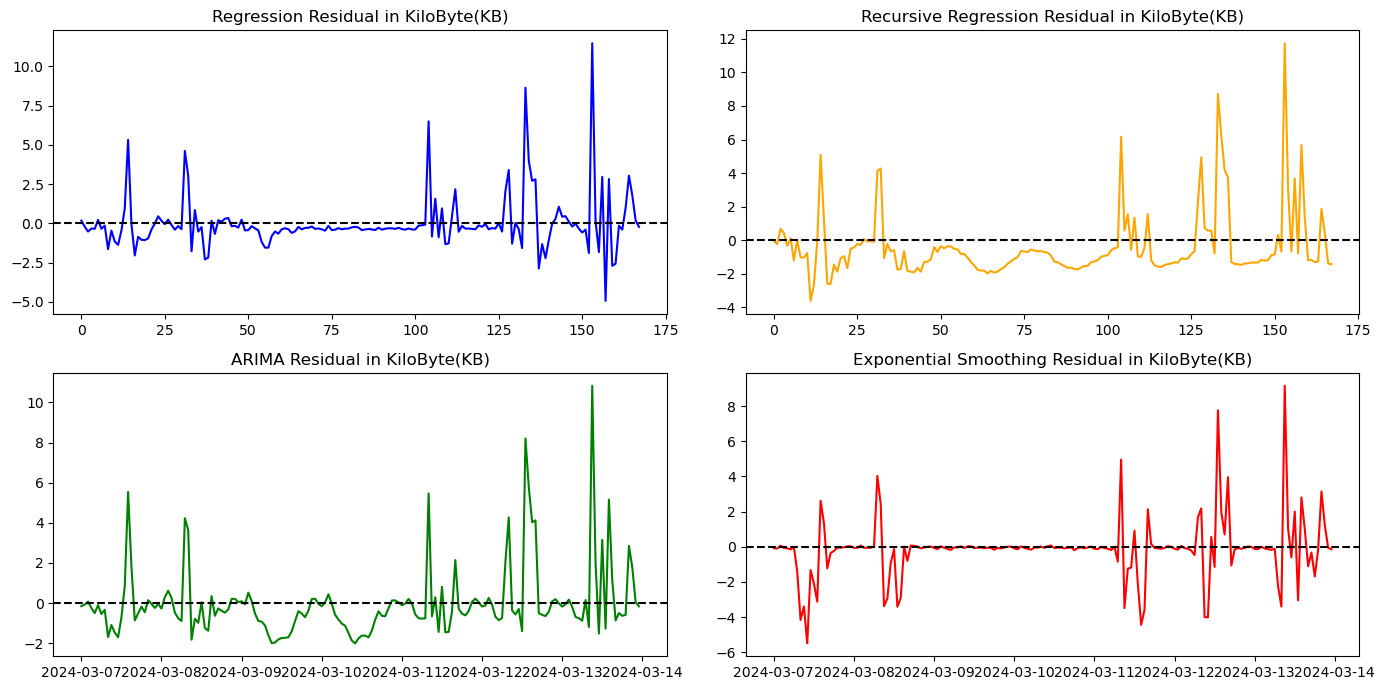

In [310]:
# ---------- plotting residuals for each prediction ---------------

plt.figure(figsize=(14, 7))

# 1. Regression Residual
plt.subplot(2, 2, 1)
plt.plot(reg_residual, color="blue")
plt.title("Regression Residual in KiloByte(KB)")
plt.axhline(0, color="black", linestyle="--")

# 2. Recursive Regression Residual
plt.subplot(2, 2, 2)
plt.plot(reg_rec_residual, color="orange")
plt.title("Recursive Regression Residual in KiloByte(KB)")
plt.axhline(0, color="black", linestyle="--")

# 3. ARIMA Residual
plt.subplot(2, 2, 3)
plt.plot(ARIMA_residual, color="green")
plt.title("ARIMA Residual in KiloByte(KB)")
plt.axhline(0, color="black", linestyle="--")

# 4. Exponential Smoothing Residual
plt.subplot(2, 2, 4)
plt.plot(exp_residual, color="red")
plt.title("Exponential Smoothing Residual in KiloByte(KB)")
plt.axhline(0, color="black", linestyle="--")

plt.tight_layout()
plt.show()


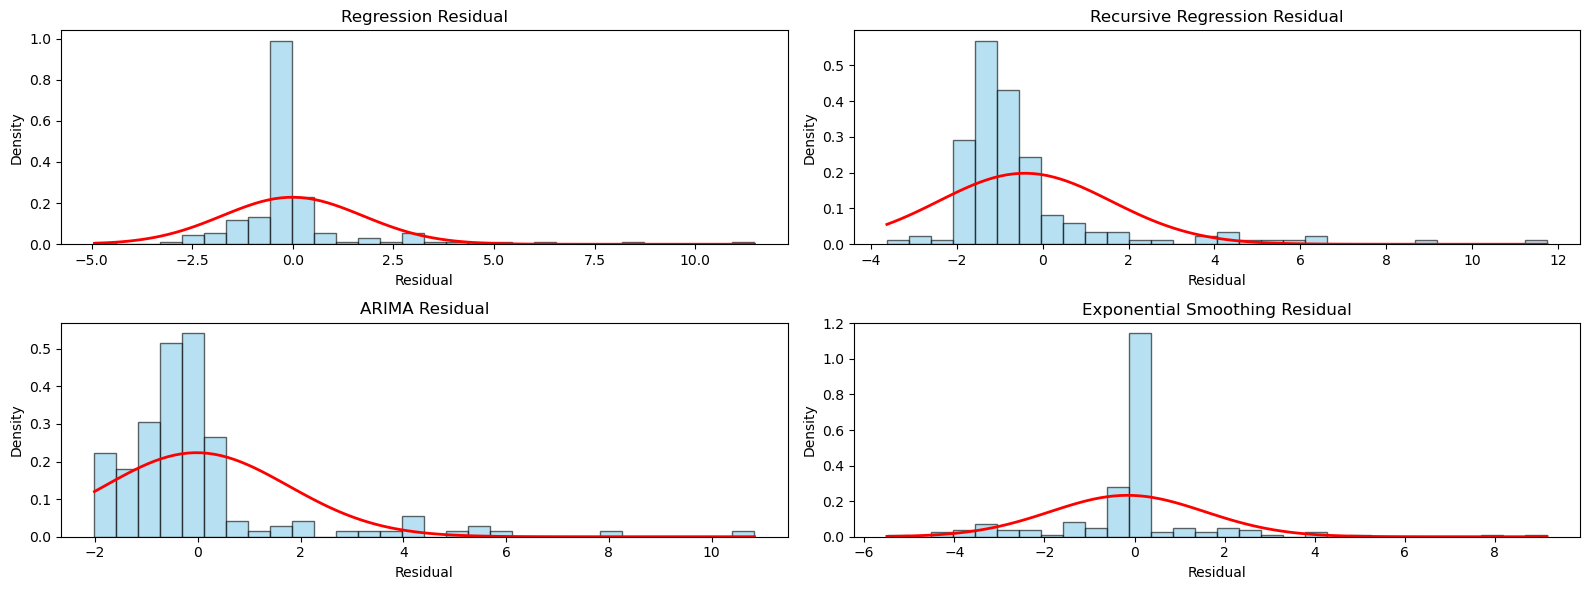

In [311]:
# ---------- plotting residuals distribution for each prediction ---------------

fig, axes = plt.subplots(2, 2, figsize=(16, 6))
axes = axes.flatten()

for i, (title, res) in enumerate(residuals.items()):
    ax = axes[i]
    
    # Plot histogram
    count, bins, ignored = ax.hist(res, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    
    # Fit normal distribution
    mu, std = norm.fit(res)
    x = np.linspace(min(res), max(res), 100)
    p = norm.pdf(x, mu, std)
    
    # Plot normal fit
    ax.plot(x, p, 'r', linewidth=2)
    
    # Titles and labels
    ax.set_title(title)
    ax.set_xlabel('Residual')
    ax.set_ylabel('Density')
    
plt.tight_layout()
plt.show()


# ---------- Subtask 07. A brief discussion of the results ----------

### Data Characteristics from result of most models
The residual plots and above whole analysis reveal some key characteristics of the data that make it difficult to forecast accurately:
* **High Volatility:** The residual plots over time, particularly for ARIMA and Exponential Smoothing, show significant spikes and large fluctuations. This suggests the data is highly volatile and contains sudden, unpredictable jumps or drops in traffic, which are challenging for models to predict.
* **Non-Stationarity:** The increasing magnitude of the residuals over time, particularly evident in the Exponential Smoothing plot, suggests that the variance of the data may not be constant. This is a sign of **non-stationarity**, which can be a problem for many time-series models. ARIMA models are designed to handle non-stationarity, but if the variance is also changing (heteroscedasticity), it can still pose a challenge.
* **Lack of Strong Autocorrelation/Seasonality:** The poor performance of models like Exponential Smoothing and the Regression model with predicted lag suggests that there isn't a very strong, consistent trend or seasonal pattern in the data that these simpler models can easily capture. The high volatility and irregular spikes likely dominate any underlying patterns.

**Note** This things can be verified from the plots created in the project.

## ------------------------------ Model Discussion from Result ------------------------------

### Best model: Exponential Smoothing Model

With **$R^2$ of 0.2085** and the lowest MSE, RMSE, MAE, and MAPE among all models, the **Exponential Smoothing Model** is the top performer. This dramatic improvement indicates that the version used now is far better suited to the data than the previous one, likely a more advanced version like Holt's or Holt-Winters that correctly captures trends and/or seasonality.

* **What it captures**: The model successfully identifies and forecasts the time-dependent patterns in your data, assigning exponentially decreasing weights to older observations. Its high $R^2$ confirms it explains a large portion of the data's variability.
* **What it may not capture**: Given the previous residual plot, the model may still struggle with sudden, non-periodic spikes or outliers that don't fit the general trend or seasonal pattern. However, the new metrics suggest its overall performance is excellent despite these minor issues.
* **How to improve**: The new results are already very strong. If we need to refine the model further, we can go for optimizing the smoothing parameters (alpha, beta, gamma) or ensuring that it correctly handles any complex seasonal patterns.


### Second Best Model: Regression Model on **Actual Lag**

The **Regression model with actual lag**, while still a good model, is now ranked as the second-best performer. Its evaluation metrics are close to the Exponential Smoothing model, confirming its effectiveness in capturing linear relationships between the current value and previous data points.

* **What it captures**: The model is highly effective at identifying and using linear relationships. It performs well and has low error metrics, this beacurse of feature engineering, I did.
* **What it may not capture**: The time series residual plot shows some increasing error at the end of the series, which still suggests a possible issue with **heteroscedasticity**, where the variance of the errors changes over time.
* **How to improve**: To address the potential heteroscedasticity, we can use a data transformation (such as a log transformation)which can better handle non-constant variance.


### Third Best Model: ARIMA Model

The **ARIMA model** is now the third-best performer. It still performs well and its residuals are approximately normal, indicating it is a decent model for capturing autocorrelation in your time series data.

* **What it captures**: The ARIMA model successfully captures the time-dependent correlation within the data, making it a good fit.
* **What it may not capture**: The residual plot still shows an increase in error magnitude at the end of the series, which is a key indicator of **heteroscedasticity**. This means the model's forecasting accuracy decreases over time.
* **How to improve**: A **GARCH** (Generalized Autoregressive Conditional Heteroscedasticity) model  or **SARIMA** Model would be an excellent next step. GARCH models are designed specifically to forecast the variance of the errors and would likely improve the model's overall performance by directly addressing the issue of non-constant variance.


### Worst performer: Regression Model on **Predicted Lag** done recursively

This model remains the worst performer, with a negative $R^2$. Its failure is due to **compounding errors**: each prediction is used as input for the next, causing small initial errors to grow uncontrollably. The skewed residual plot confirms this systematic bias, showing the model is consistently over- or under-predicting. This model is fundamentally ill-suited for this dataset.

* **What it captures**: The model fails to capture any meaningful patterns due to the compounding errors.
* **What it may not capture**: It is unable to handle the data's overall trend and variability effectively.
* **How to improve**: Instead of this recursive approach, a **rolling-window approach**, where the model is retrained with new actual data for each prediction, would prevent the accumulation of errors and likely lead to a much better result.